# Worksheet 3b - ARIMAX, SARIMAX and LSTMs

Designed by Prateek Rao - xrprateek@gmail.com

In the previous worksheet, we experimented with ARIMA models. However, one caveat of ARIMA (or similar models), is that it takes only the target variable into consideration, according to the timestamp. In essence, it derives the relationship between the current target variable values and the past variable values.

However, what if we have some other external factors affecting the target values?
This is where *ARIMAX* (AutoRegressive Integrated Moving Average with eXogenous variables) steps in!

ARIMAX extends the capabilities of ARIMA by incorporating external factors or exogenous variables that influence the time series data. It's the bridge that connects the simplicity of ARIMA with the complexity of real-world forecasting, allowing us to tackle more intricate and realistic forecasting challenges.

## Imports

Make sure you have the following libraries installed!

In [ ]:
# !pip install scikit-learn
# !pip install keras
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install statsmodels

In [1]:


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## Loading the data

The dataset `electricity.csv` has been given to you. Let's load it using pandas.

In [2]:
import pandas as pd
df = pd.read_csv("53.electricity.csv")

In [3]:
df.head()

,day,power_consumed,weather_index,holiday_index,maximum_temperature,humidity,wind_velocity,pressure,rainfall
0,2011-11-23,6.952692,1,0,10.36,6.29,2.04,1027.12,13
1,2011-11-24,8.536480,1,0,12.93,8.56,4.04,1027.22,25
2,2011-11-25,9.499781,0,0,13.03,7.24,5.02,1024.47,32
3,2011-11-26,10.267707,0,0,12.96,6.96,5.75,1025.80,41
4,2011-11-27,10.850805,0,0,13.54,5.76,5.48,1021.11,41


### Data Dictionary:

* `power_consumed`: *Target variable*. Electricity consumed by a household.
* `weather_index` : A cluster assigned to type of weather, through previous preprocessing. For instance, cloudy could be 1, sunny could be 2, etc.
* `holiday_index` : 0 if it's a working day, 1 if it's a holiday.
* `maximum_temperature` : Max temperature of the particular day. 
* `humidity` : Humidity measured as dew point.
* `wind_velocity` : Average wind speed.
* `pressure` : Atmospheric pressure in the locality.
* `rainfall` : Average rainfall amount.

We intend to perform electricity usage forecasting over every single day, used by a household. At this stage, a suggestion would be to start thinking about your knowledge with respect to electricity bills. Are there specific months when you'd expect higher power consumption over some other months? Do you think this could be effectively modeled with some time series methods that you have learnt of, in your course?

Remember, we are performing time series analysis here. A general rule of thumb is to have the `time` column as the index column!

In [9]:
df['day'] = pd.to_datetime(df['day'])
df.set_index(['day'],inplace=True)

Before we try to forecast anything, let's go ahead and split the dataset into train-test sets, as discussed in the previous worksheet. 
Remember, since we're dealing with time series data, we will not perform a random split! 

In [10]:
train = df.iloc[0:(len(df)-30)]
test = df.iloc[len(train):(len(df)-1)]

Since this is a small dataset, and is being used only for demonstration purposes, we've used a split of only 30 instances for testing and the rest for training.

In the real world, we'd prefer using a 70-15-15 % split for train-test-val, or 80-20 for train-test, as required by the problem.

In [11]:
train.head()

,power_consumed,weather_index,holiday_index,maximum_temperature,humidity,wind_velocity,pressure,rainfall
day,,,,,,,,
2011-11-23,6.952692,1,0,10.36,6.29,2.04,1027.12,13
2011-11-24,8.536480,1,0,12.93,8.56,4.04,1027.22,25
2011-11-25,9.499781,0,0,13.03,7.24,5.02,1024.47,32
2011-11-26,10.267707,0,0,12.96,6.96,5.75,1025.80,41
2011-11-27,10.850805,0,0,13.54,5.76,5.48,1021.11,41


<Axes: xlabel='day'>

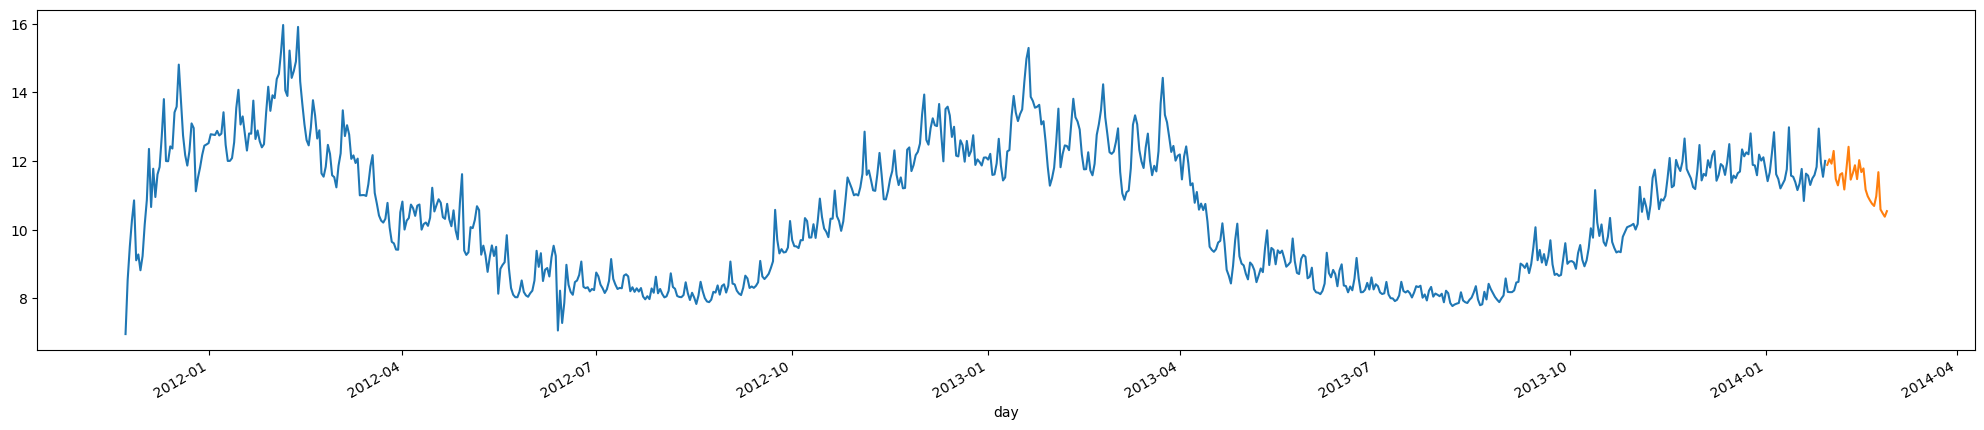

In [12]:
train['power_consumed'].plot(figsize=(25,5))
test['power_consumed'].plot(figsize=(25,5))

## Augmented Dickey-Fuller Test

In [13]:

t = sm.tsa.adfuller(train.power_consumed, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  -1.872794
p-value                          0.344966
#Lags Used                      21.000000
Number of Observations Used    776.000000
dtype: float64

We can see that $p > 0.05$, hence the data is not stationary. We need to implement some sort of differencing to make the data stationary.   

In [14]:
train['differenced_values'] = train['power_consumed'].diff(1)
train.dropna(inplace=True)



/var/folders/wd/ldk602c94y92bspz_m11w0gm0000gn/T/ipykernel_2697/2826590722.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['differenced_values'] = train['power_consumed'].diff(1)
/var/folders/wd/ldk602c94y92bspz_m11w0gm0000gn/T/ipykernel_2697/2826590722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)


In [15]:
t = sm.tsa.adfuller(train.differenced_values, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                -6.715004e+00
p-value                        3.600554e-09
#Lags Used                     2.000000e+01
Number of Observations Used    7.760000e+02
dtype: float64

Single order differencing seems to work here! We can see that $p < 0.05$ now

## Decomposition of elements

In [16]:
s = sm.tsa.seasonal_decompose(train.power_consumed, period=12)

<Axes: xlabel='day'>

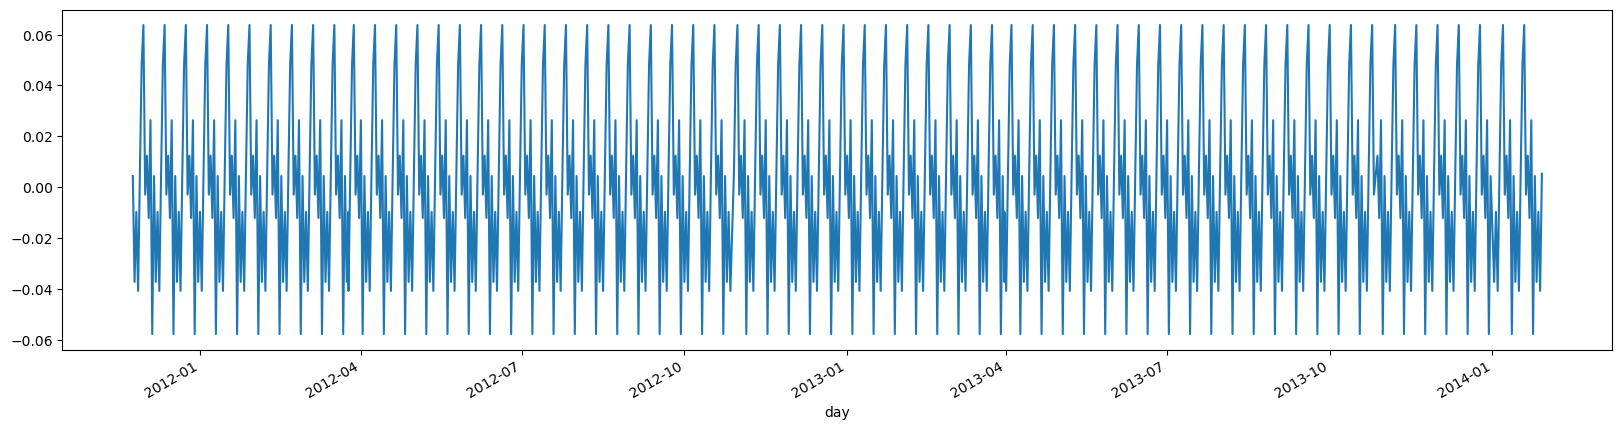

In [17]:
s.seasonal.plot(figsize=(20,5))

<Axes: xlabel='day'>

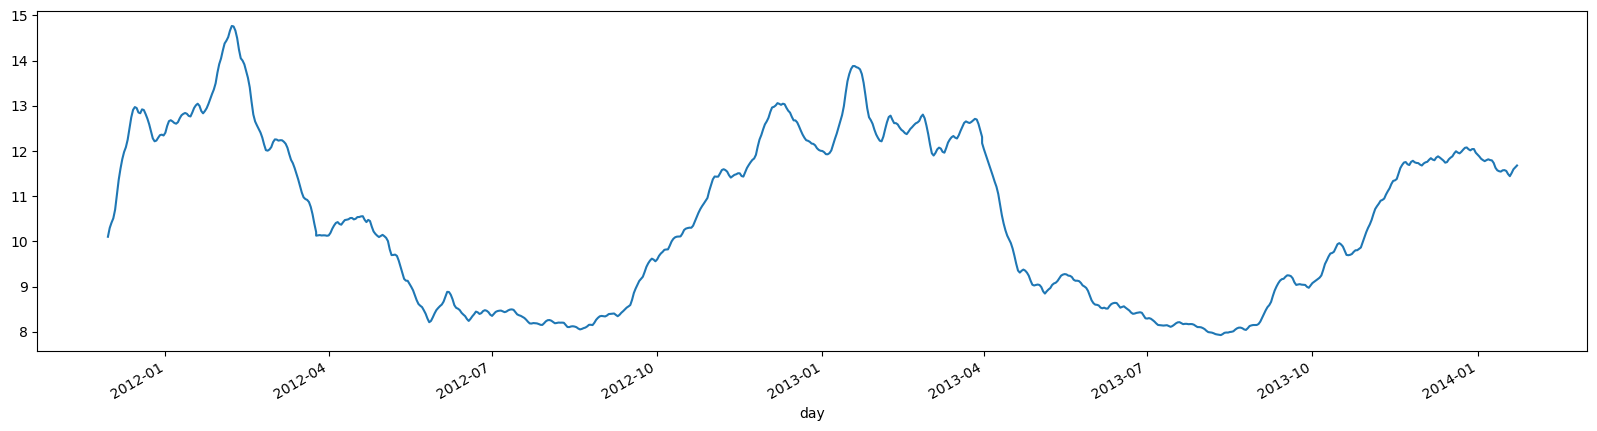

In [18]:
s.trend.plot(figsize=(20,5))

<Axes: xlabel='day'>

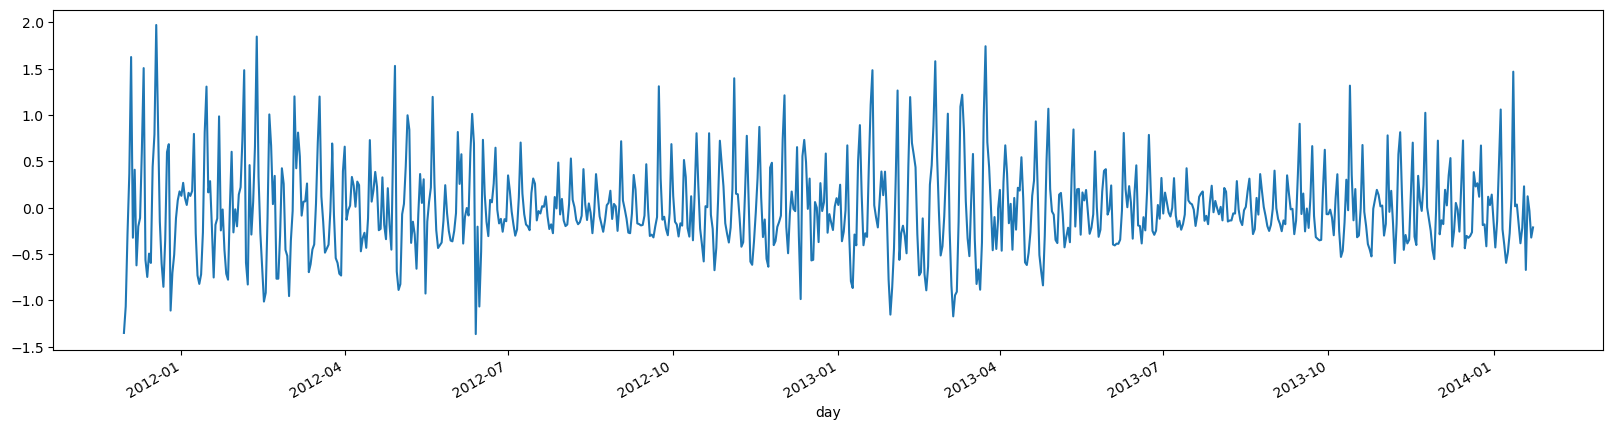

In [19]:
s.resid.plot(figsize=(20,5))

## ARIMAX Model

In [20]:
train.columns

Index(['power_consumed', 'weather_index', 'holiday_index',
       'maximum_temperature', 'humidity', 'wind_velocity', 'pressure',
       'rainfall', 'differenced_values'],
      dtype='object')

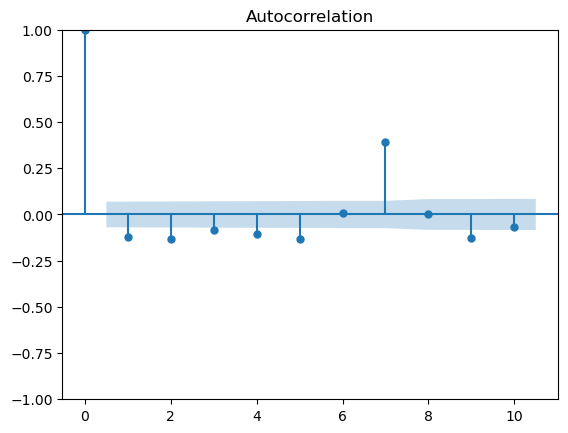

In [21]:

plot_acf(train.differenced_values,lags=10)
plt.show()

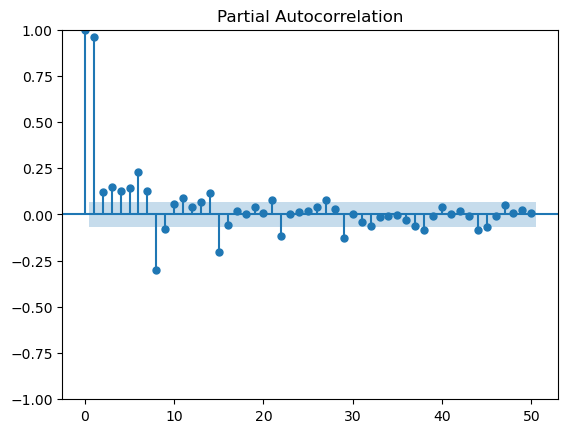

In [22]:
plot_pacf(train.power_consumed,lags=50)
plt.show()

Here, we define an algorithm which takes in a range of values of p, d, q and calculates the AIC metric on a vanilla ARIMA model. 

The **Akaike Information Criterion (AIC)** is a statistical measure used for model selection and comparison in the context of regression analysis and time series modeling.

AIC quantifies the trade-off between a model's goodness of fit and its complexity, penalizing models with too many parameters. It is employed to choose the best-fitting model among a set of candidate models. The model with the lowest AIC value is typically preferred because it represents a good balance between explaining the data and avoiding overfitting.

In [23]:
#Finding the best value for ARIMA
import warnings
warnings.filterwarnings("ignore")

import itertools 
p=q=range (0,8)
d = range(0,2)
pdq = list(itertools.product (p, d, q))

store = {}
for param in pdq:
       try:
              model_arima = sm.tsa.arima.ARIMA (train.power_consumed, order = param)
              model_arima_fit = model_arima.fit()
              store[param] =  model_arima_fit.aic  
              #print(param, model_arima_fit.aic)
       except:
              continue
          
sorted_dict = dict(sorted(store.items(), key=lambda item: item[1]))
print(sorted_dict)
# The Akaike information criterion (AIC) is an estimator of in-sample prediction error and thereby relative quality of
# statistical models for a given set of data
# It's like the mean squared error in Regression - The smaller the number, the better

{(7, 1, 7): 905.9814090538409, (6, 1, 7): 908.9199783311169, (7, 0, 7): 921.6286499439136, (7, 0, 6): 926.2582763431715, (6, 1, 6): 928.4326209807707, (7, 1, 6): 939.6190885187287, (5, 1, 4): 945.4231802877894, (6, 1, 5): 946.0018430492428, (5, 1, 5): 946.3854200449507, (4, 1, 6): 949.1293221766458, (7, 1, 5): 950.1281847036818, (7, 0, 5): 950.4302431316561, (4, 1, 5): 950.496109498053, (5, 1, 7): 951.2727066960779, (5, 1, 6): 952.8133305767044, (6, 0, 5): 954.932145170656, (5, 0, 7): 955.8471537766472, (6, 0, 4): 956.6943737469578, (6, 0, 6): 957.4675172279274, (6, 0, 7): 957.5843603892273, (5, 0, 6): 960.5269038153608, (5, 0, 5): 960.880937750156, (6, 1, 4): 973.290447467363, (7, 1, 4): 980.5399822593126, (7, 0, 4): 980.9902486966823, (4, 1, 7): 996.6413993497098, (7, 1, 2): 1004.88366049671, (7, 1, 3): 1006.1100844359473, (7, 1, 1): 1008.7395229074356, (7, 1, 0): 1010.2051315033403, (6, 1, 2): 1012.2720785755013, (6, 1, 3): 1014.2968021281249, (4, 1, 2): 1014.7581507967873, (5, 1, 3

In [30]:
endog = train['power_consumed']
exog = sm.add_constant(train[['weather_index', 'holiday_index',
       'maximum_temperature', 'humidity', 'wind_velocity', 'pressure',
       'rainfall']])

mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(7,1,7))
model_fit = mod.fit()
model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32599D+01    |proj g|=  1.16420D+02


 This problem is unconstrained.



At iterate    5    f=  3.22238D+00    |proj g|=  4.29164D+01

At iterate   10    f=  1.91987D+00    |proj g|=  1.49151D+01

At iterate   15    f=  1.15331D+00    |proj g|=  1.04605D+00

At iterate   20    f=  1.05159D+00    |proj g|=  2.78782D+00

At iterate   25    f=  8.71755D-01    |proj g|=  4.06431D+00

At iterate   30    f=  7.43435D-01    |proj g|=  1.90966D+00

At iterate   35    f=  6.92699D-01    |proj g|=  1.30274D+00

At iterate   40    f=  6.89531D-01    |proj g|=  1.51632D+00

At iterate   45    f=  6.54207D-01    |proj g|=  6.44391D-01

At iterate   50    f=  6.19202D-01    |proj g|=  1.09467D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         power_consumed   No. Observations:                  797
Model:               SARIMAX(7, 1, 7)   Log Likelihood                -493.504
Date:                Wed, 18 Oct 2023   AIC                           1033.007
Time:                        20:13:47   BIC                           1140.638
Sample:                             0   HQIC                          1074.364
                                - 797                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -4.693e-09   1.43e-08     -0.328      0.743   -3.28e-08    2.34e-08
weather_index           0.0188      0.028      0.670      0.503      -0.036       0.074
holiday_index          -0.0770      0.081     -0.953      0.341      -0.235       0.081
maximum_temperature    -0.0307      0.007     -4.404      0.000      -0.044      -0.017
humidity               -0.0114      0.008     -1.456      0.146      -0.027       0.004
wind_velocity          -0.0040      0.011     -0.372      0.710      -0.025       0.017
pressure               -0.0108      0.002     -4.595      0.000      -0.015      -0.006
rainfall               -0.0006      0.000     -1.441      0.150      -0.001       0.000
ar.L1                  -0.2327      0.116     -2.010      0.044      -0.460      -0.006
ar.L2                  -0.0348      0.129     -0.269      0.788      -0.288       0.219
ar.L3                  -0.4985      0.091     -5.471      0.000      -0.677      -0.320
ar.L4                   0.0651      0.107      0.607      0.544      -0.145       0.275
ar.L5                  -0.1857      0.083     -2.224      0.026      -0.349      -0.022
ar.L6                  -0.1354      0.085     -1.593      0.111      -0.302       0.031
ar.L7                   0.5627      0.084      6.702      0.000       0.398       0.727
ma.L1                   0.0986      0.114      0.864      0.388      -0.125       0.322
ma.L2                  -0.1009      0.121     -0.836      0.403      -0.337       0.136
ma.L3                   0.5574      0.065      8.632      0.000       0.431       0.684
ma.L4                  -0.3598      0.083     -4.356      0.000      -0.522      -0.198
ma.L5                  -0.1798      0.060     -3.012      0.003      -0.297      -0.063
ma.L6                   0.1936      0.052      3.706      0.000       0.091       0.296
ma.L7                  -0.5137      0.060     -8.588      0.000      -0.631      -0.396
sigma2                  0.1932      0.008     22.991      0.000       0.177       0.210
===================================================================================
Ljung-Box (L1) (Q):                  22.32   Jarque-Bera (JB):                66.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.38e+23. Standard errors may be unstable.
"""

Plotting the predicted values on the train set - shows a decent prediction

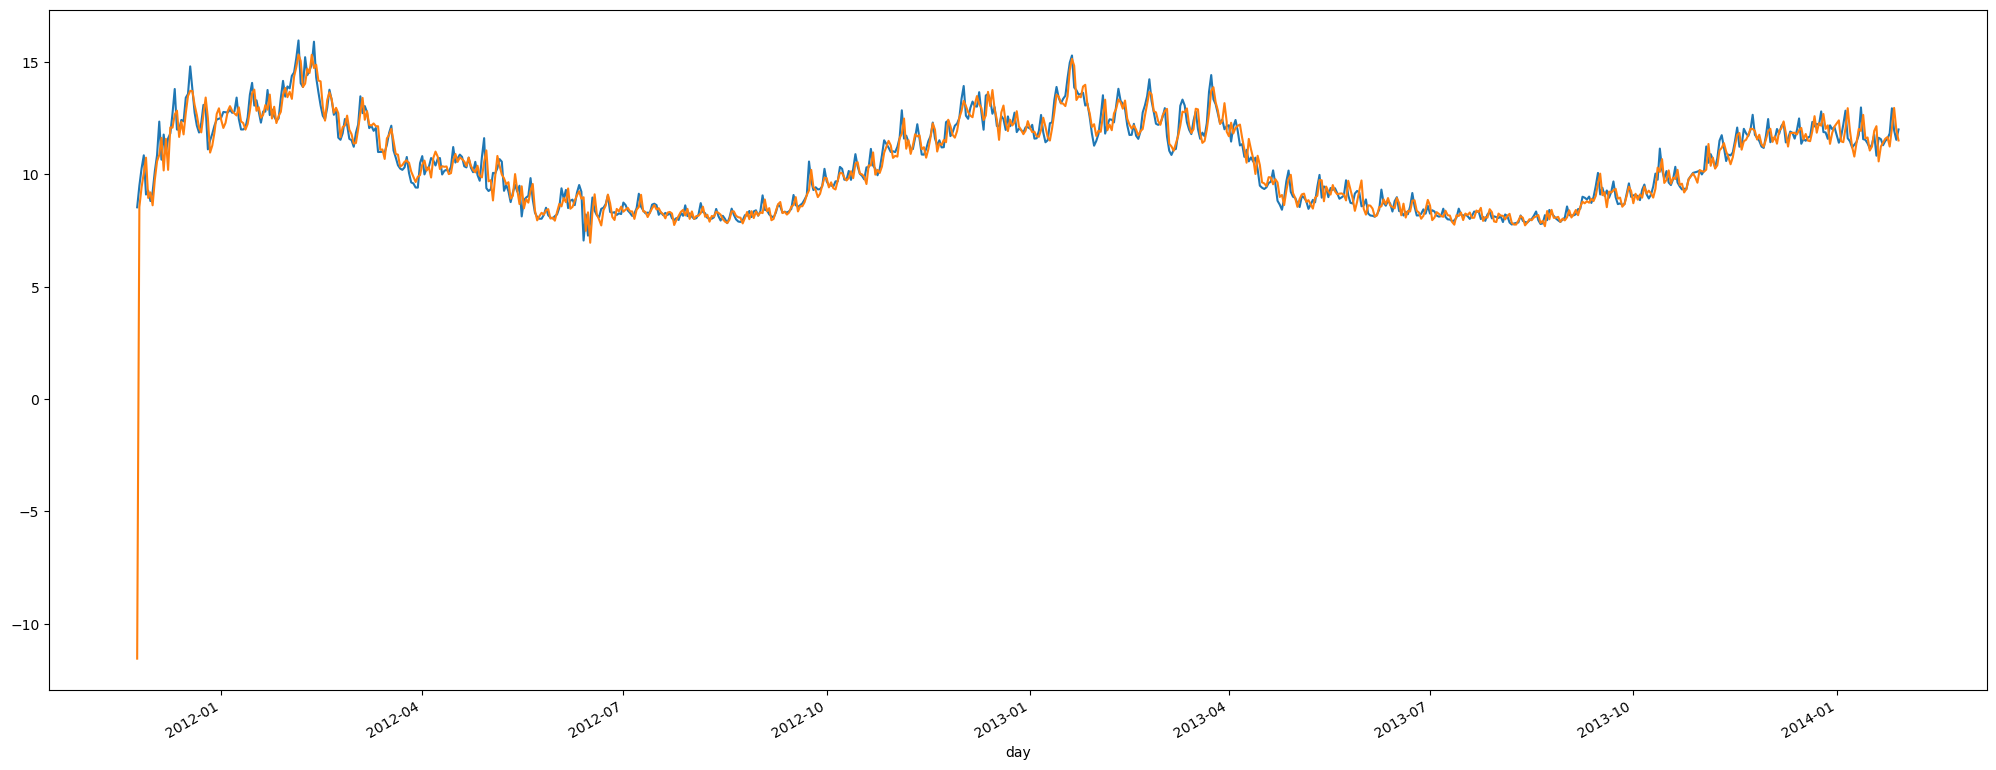

In [31]:
train['power_consumed'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

With this piece of code, we shall perform model inference. 
We'll use our hold-out test set for this. Using the exogenous variables, we'll provide input into our fitted ARIMAX model, and obtain the predcitions for `power_consumed`

In [32]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[['weather_index', 'holiday_index', 'maximum_temperature', 'humidity', 'wind_velocity', 'pressure', 'rainfall']]))
test['predicted'] = predict.values
test.tail(5)

,power_consumed,weather_index,holiday_index,maximum_temperature,humidity,wind_velocity,pressure,rainfall,predicted
day,,,,,,,,,
2014-02-23,11.673756,0,0,11.94,6.17,7.10,1010.37,4998,11.699050
2014-02-24,10.586235,0,0,14.23,6.03,5.02,1005.19,4994,11.599840
2014-02-25,10.476498,0,0,11.43,5.06,5.69,1000.65,4995,11.620502
2014-02-26,10.375366,0,0,11.29,2.74,3.82,1012.73,4993,11.577150
2014-02-27,10.537250,0,0,10.31,3.08,4.14,1007.02,4990,11.721616


We've defined 2 metrics here - MAE and MAPE, to quantify our loss here.

In [33]:
MAE = mean_absolute_error(test["power_consumed"], test["predicted"])
RMSE = math.sqrt(mean_squared_error(test["power_consumed"], test["predicted"]))
print("MAE:", MAE)
print("RMSE:", RMSE)

MAE: 0.49738637681066733
RMSE: 0.6105802134264131


We plot the predicted values vs. the actual values for the test set.

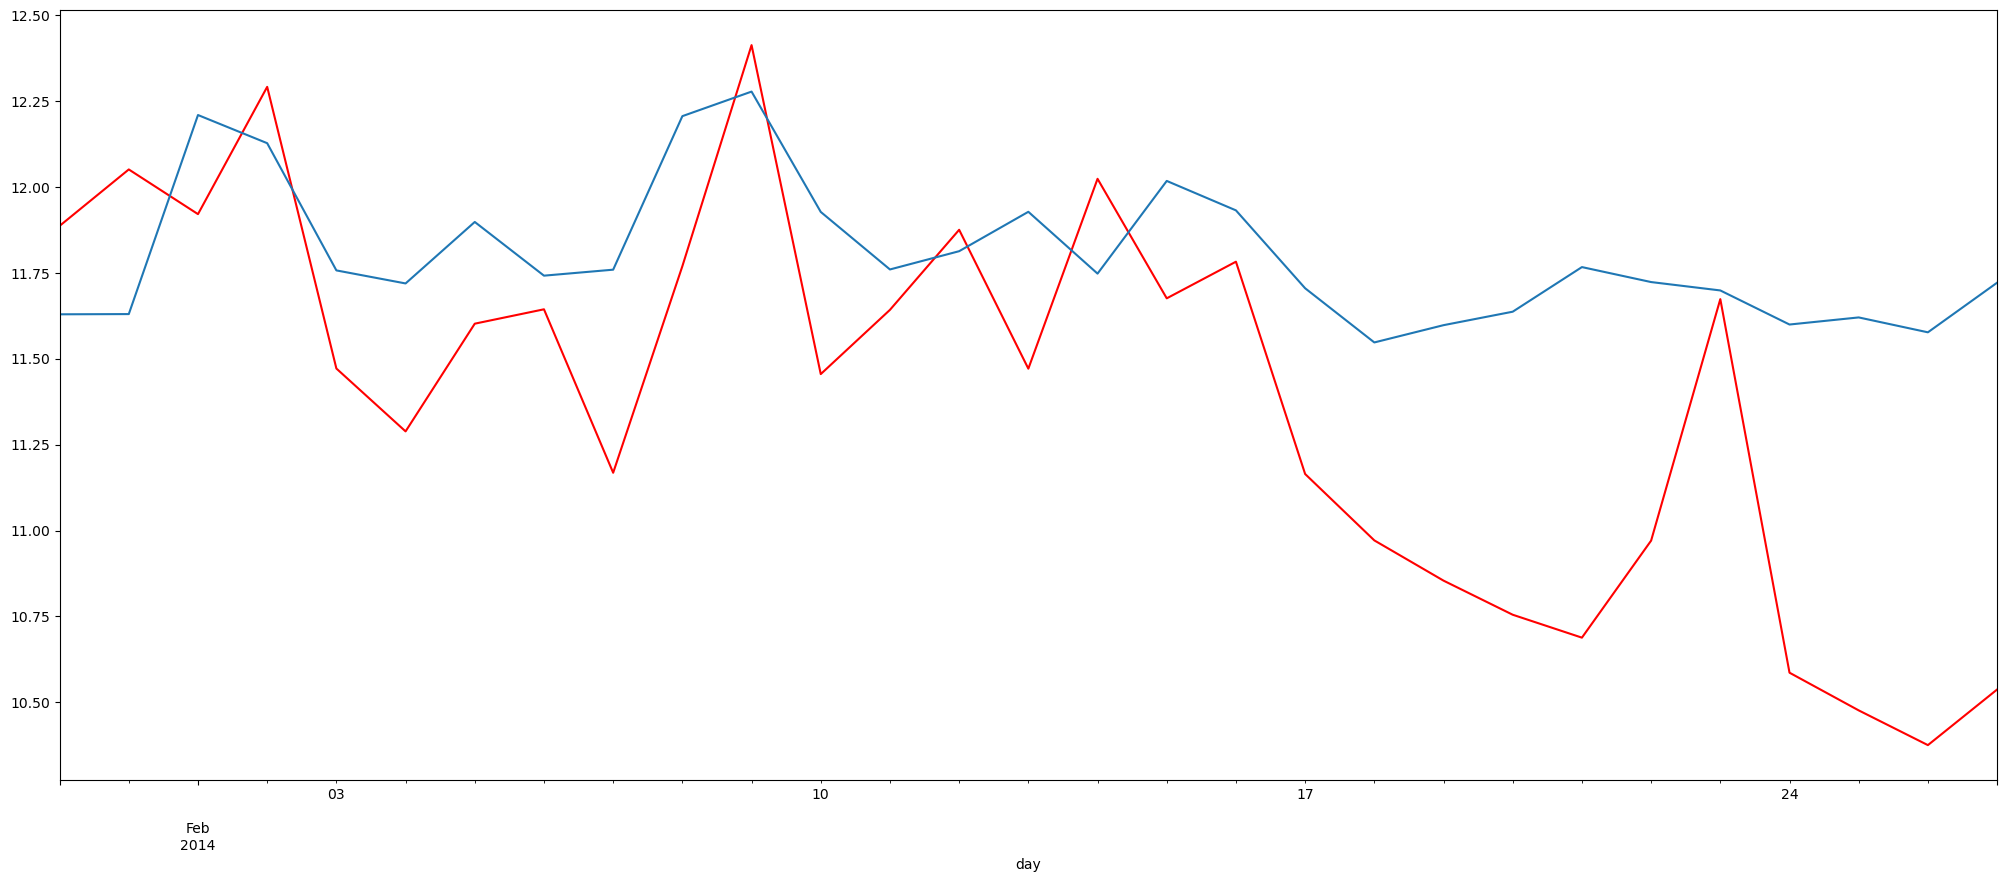

In [34]:
test['power_consumed'].plot(figsize=(25,10),color = 'red')
test['predicted'].plot()
plt.show()

# Question 1: Your task is to use the above learnings, and apply a SARIMAX model. Do reuse the code, identify a suitable seasonal order, and experiment to find the best performing model! Also, provide your reasoning for choosing your seasonal order!

> Hint: In your model definition step, you'll have to provide a `seasonal_order` parameter along with `order`. 

In [62]:
import itertools

# Define a range of seasonal parameters to search
P = range(0, 2)  # Range for seasonal order of SAR component
D = range(0, 2)  # Range for seasonal order of seasonal differencing
Q = range(0, 2)  # Range for seasonal order of SMA component
s = 7  # Seasonal period (assuming daily data, s=7 for weekly seasonality)

# Create all possible combinations of seasonal orders
seasonal_order = list(itertools.product(P, D, Q))

# Initialize variables to store best parameters and lowest AIC
best_seasonal_order = None
best_aic = float('inf')

# Iterate through the combinations and fit SARIMAX models
for seasonal in seasonal_order:
# Update the non-seasonal order
    current_order = (4, 1, 3)  # Your non-seasonal order (modified)
    current_seasonal_order = seasonal + (s,)  # Add the seasonal period
    mod = sm.tsa.statespace.SARIMAX(train.power_consumed, order=current_order, seasonal_order=current_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)

    model_fit = mod.fit()

    # Check AIC for this model
    current_aic = model_fit.aic

    # Update the best seasonal order if the AIC is lower
    if current_aic < best_aic:
        best_aic = current_aic
        best_seasonal_order = current_seasonal_order

print("Best Seasonal Order:", best_seasonal_order)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43822D+00    |proj g|=  6.24583D-01

At iterate    5    f=  8.61131D-01    |proj g|=  4.04949D-01

At iterate   10    f=  7.94613D-01    |proj g|=  2.00468D-01

At iterate   15    f=  6.66832D-01    |proj g|=  9.37376D-02

At iterate   20    f=  6.63255D-01    |proj g|=  1.52714D-01

At iterate   25    f=  6.57143D-01    |proj g|=  1.14624D-01

At iterate   30    f=  6.41442D-01    |proj g|=  2.71371D-01

At iterate   35    f=  6.36690D-01    |proj g|=  1.78800D-01

At iterate   40    f=  6.30844D-01    |proj g|=  2.56837D-02

At iterate   45    f=  6.30805D-01    |proj g|=  1.24238D-02

At iterate   50    f=  6.30315D-01    |proj g|=  1.65399D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.41725D-01    |proj g|=  6.60808D-01

At iterate   10    f=  6.76545D-01    |proj g|=  3.46898D-01

At iterate   15    f=  6.47800D-01    |proj g|=  3.94072D-01

At iterate   20    f=  6.28419D-01    |proj g|=  6.39162D-01

At iterate   25    f=  6.22283D-01    |proj g|=  3.64163D-01

At iterate   30    f=  6.14460D-01    |proj g|=  6.36977D-01

At iterate   35    f=  6.03903D-01    |proj g|=  1.22980D-01

At iterate   40    f=  5.97095D-01    |proj g|=  1.32416D-01

At iterate   45    f=  5.96311D-01    |proj g|=  6.63789D-02

At iterate   50    f=  5.92095D-01    |proj g|=  6.53319D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.11736D+00    |proj g|=  1.31128D+00

At iterate   15    f=  8.27397D-01    |proj g|=  8.75328D-01

At iterate   20    f=  7.93075D-01    |proj g|=  3.34028D-01

At iterate   25    f=  7.82119D-01    |proj g|=  1.04841D-01

At iterate   30    f=  7.81238D-01    |proj g|=  2.14813D-02

At iterate   35    f=  7.79552D-01    |proj g|=  7.73468D-02

At iterate   40    f=  7.71572D-01    |proj g|=  4.38499D-02

At iterate   45    f=  7.70595D-01    |proj g|=  2.11678D-02

At iterate   50    f=  7.70046D-01    |proj g|=  6.61645D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63   

 This problem is unconstrained.



At iterate    5    f=  1.18866D+00    |proj g|=  1.37596D+00

At iterate   10    f=  7.11070D-01    |proj g|=  5.59440D-01

At iterate   15    f=  5.88975D-01    |proj g|=  1.90950D-01

At iterate   20    f=  5.67408D-01    |proj g|=  9.49607D-02

At iterate   25    f=  5.63613D-01    |proj g|=  2.52505D-03

At iterate   30    f=  5.63573D-01    |proj g|=  1.33244D-02

At iterate   35    f=  5.63552D-01    |proj g|=  3.31524D-03

At iterate   40    f=  5.63550D-01    |proj g|=  1.02953D-03

At iterate   45    f=  5.63526D-01    |proj g|=  7.82496D-03

At iterate   50    f=  5.63027D-01    |proj g|=  1.35219D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  6.21272D-01    |proj g|=  1.98866D-01

At iterate   20    f=  6.00324D-01    |proj g|=  1.69744D-01

At iterate   25    f=  5.88229D-01    |proj g|=  3.39190D-01

At iterate   30    f=  5.83565D-01    |proj g|=  7.74713D-02

At iterate   35    f=  5.82986D-01    |proj g|=  1.27096D-01

At iterate   40    f=  5.81812D-01    |proj g|=  4.63082D-02

At iterate   45    f=  5.81499D-01    |proj g|=  5.31494D-03

At iterate   50    f=  5.81322D-01    |proj g|=  1.10009D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     74      1     0     0   1.100D-01   5.813D-01
  F =  0.581322330253

 This problem is unconstrained.



At iterate    5    f=  6.08292D-01    |proj g|=  3.02716D-01

At iterate   10    f=  5.70250D-01    |proj g|=  1.99047D-01

At iterate   15    f=  5.44353D-01    |proj g|=  1.00628D-01

At iterate   20    f=  5.38995D-01    |proj g|=  5.41138D-02

At iterate   25    f=  5.37686D-01    |proj g|=  6.47259D-02

At iterate   30    f=  5.36606D-01    |proj g|=  1.83711D-02

At iterate   35    f=  5.36481D-01    |proj g|=  2.48115D-02

At iterate   40    f=  5.36446D-01    |proj g|=  5.68606D-03

At iterate   45    f=  5.36433D-01    |proj g|=  3.10960D-02

At iterate   50    f=  5.36340D-01    |proj g|=  5.10202D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77831D+00    |proj g|=  3.14022D-01

At iterate    5    f=  1.17623D+00    |proj g|=  3.05696D-01

At iterate   10    f=  7.34567D-01    |proj g|=  3.93854D-01

At iterate   15    f=  6.58529D-01    |proj g|=  5.16067D-02

At iterate   20    f=  6.51523D-01    |proj g|=  5.62524D-02

At iterate   25    f=  6.51286D-01    |proj g|=  1.05090D-02

At iterate   30    f=  6.49631D-01    |proj g|=  2.70316D-02

At iterate   35    f=  6.48680D-01    |proj g|=  9.49023D-02

At iterate   40    f=  6.48553D-01    |proj g|=  1.91985D-03

At iterate   45    f=  6.48550D-01    |proj g|=  4.77122D-03

At iterate   50    f=  6.48402D-01    |proj g|=  4.59172D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71157D+00    |proj g|=  4.14316D-01

At iterate    5    f=  9.91400D-01    |proj g|=  5.90353D-01

At iterate   10    f=  6.64887D-01    |proj g|=  1.78078D+00

At iterate   15    f=  5.69109D-01    |proj g|=  1.18735D-01

At iterate   20    f=  5.60254D-01    |proj g|=  3.28526D-02

At iterate   25    f=  5.59159D-01    |proj g|=  3.86929D-03

At iterate   30    f=  5.59128D-01    |proj g|=  1.93711D-03

At iterate   35    f=  5.59089D-01    |proj g|=  1.55905D-03

At iterate   40    f=  5.59061D-01    |proj g|=  2.38157D-02

At iterate   45    f=  5.58523D-01    |proj g|=  3.37822D-02

At iterate   50    f=  5.57547D-01    |proj g|=  2.83174D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number

The best seasonal order for the SARIMAX model, which is (1, 0, 1, 7). This is the seasonal order that minimizes the AIC, indicating it's the most suitable for time series data.

# LSTMs

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture in deep learning. LSTMs are designed to address the vanishing gradient problem in traditional RNNs, allowing them to effectively capture and model long-range dependencies in sequential data. They have become a crucial tool for tasks like natural language processing, time series forecasting, and sequential pattern recognition.

LSTMs are often used to effectively model complicated time-series problems, so we'll explore this further.

For the scope of this worksheet, we'll only use the target variable and it's lags as input to the LSTM. However, you're encouraged to explore how the entire input dataset can be modeled as input to the model.

Our first task would be to convert our time-series forecasting problem, into a supervised learning problem. Any ideas on how we can achieve this?

Let's first learn the distinction between a time series, and a supervised learning problem.

A time series is a sequence of numbers that are ordered by a time index. This can be thought of as a list or column of ordered values.

A supervised learning problem comprises input patterns (X) and output patterns (y), such that an algorithm can learn how to predict the output patterns from the input patterns.

Pandas has a `shift()` function, that we can use to extract **lags** from the target variable. In essence, we want to somehow bring a X->y relation with respect to the target variable, while retaining the time component.

So, what are *lags*?

Lags refer to the practice of shifting a time series data point or variable backward in time by a certain number of time units.

If you're able to understand where this is going now....

We're essentially going to create a mapping such that : 

`var(t - 1) -> var(t)`; which resembles `X -> y` !

We can go further here, and take more lags, such as `var(t - 2), var(t - 3)`, etc.!

Incase you found this prelude a little difficult to follow, consider going through a more detailed write-up here: 

[Machine Learning Mastery's Blog on converting time series to supervised learning](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)

## Applying LSTM to our dataset

In [44]:
np.random.seed(11)
dataframe = df.loc[:,'power_consumed']
dataset = dataframe.values
dataset = dataset.astype('float32')

For this demonstration purpose, we'll use lags of 7 days, and convert it into a supervised learning problem. 

Here's a function that's borrowed from the aforementioned blog, that helps us in converting the time series to a supervised problem - 

In [45]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [46]:
new_dataset = series_to_supervised(dataset, 7,1)
new_dataset.head(3)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,6.952693,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513
8,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707
9,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707,10.145910


Just to give a taste of multivariate time-series forecasting using LSTMs - we'll use `weather_index` and `holiday_index` in our input to the model as well:

In [47]:
new_dataset['weather_index'] = df.weather_index.values[7:]
new_dataset['holiday_index']= df.holiday_index.values[7:]

In [48]:
new_dataset = new_dataset.reindex(['weather_index', 'holiday_index','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
new_dataset = new_dataset.values

**Remember - we cannot use DataFrames, as LSTMs (and most other deep learning models) only accept tensors as input!**

In [49]:
type(new_dataset)

numpy.ndarray

We'll scale our features between 0 and 1 - this would be to help the process of gradient descent.

In [50]:
scaler = MinMaxScaler(feature_range=(0, 1))
new_dataset = scaler.fit_transform(new_dataset)

We'll split our dataset into train and test, as done for ARIMAX. Remember, it is still inherently a time series problem, so we will not use a random split.

In [51]:
train_lstm = new_dataset[:(len(new_dataset)-30), :]
test_lstm = new_dataset[(len(new_dataset)-30):len(new_dataset), :]

We adjust the labels, such that `train_X` and `test_X` contain the features, and `train_Y`, `test_Y` contain the target

In [52]:
train_X, train_y = train_lstm[:, :-1], train_lstm[:, -1]
test_X, test_y = test_lstm[:, :-1], test_lstm[:, -1]

The input to a LSTM is 3D - in this format: (samples, timesteps, features). We'll go ahead and reshape our train and tests sets as such

In [53]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(791, 1, 9) (791,) (30, 1, 9) (30,)


## LSTM Modeling!

Epoch 1/50
11/11 - 1s - loss: 0.6683 - 908ms/epoch - 83ms/step
Epoch 2/50
11/11 - 0s - loss: 0.5702 - 11ms/epoch - 1ms/step
Epoch 3/50
11/11 - 0s - loss: 0.4698 - 13ms/epoch - 1ms/step
Epoch 4/50
11/11 - 0s - loss: 0.3617 - 13ms/epoch - 1ms/step
Epoch 5/50
11/11 - 0s - loss: 0.2408 - 13ms/epoch - 1ms/step
Epoch 6/50
11/11 - 0s - loss: 0.1104 - 14ms/epoch - 1ms/step
Epoch 7/50
11/11 - 0s - loss: 0.0693 - 14ms/epoch - 1ms/step
Epoch 8/50
11/11 - 0s - loss: 0.0719 - 12ms/epoch - 1ms/step
Epoch 9/50
11/11 - 0s - loss: 0.0642 - 11ms/epoch - 1ms/step
Epoch 10/50
11/11 - 0s - loss: 0.0598 - 12ms/epoch - 1ms/step
Epoch 11/50
11/11 - 0s - loss: 0.0574 - 13ms/epoch - 1ms/step
Epoch 12/50
11/11 - 0s - loss: 0.0554 - 13ms/epoch - 1ms/step
Epoch 13/50
11/11 - 0s - loss: 0.0530 - 12ms/epoch - 1ms/step
Epoch 14/50
11/11 - 0s - loss: 0.0511 - 12ms/epoch - 1ms/step
Epoch 15/50
11/11 - 0s - loss: 0.0492 - 12ms/epoch - 1ms/step
Epoch 16/50
11/11 - 0s - loss: 0.0472 - 14ms/epoch - 1ms/step
Epoch 17/50
11/

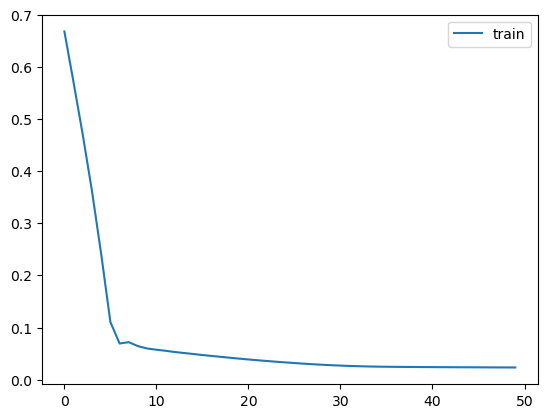

In [54]:
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

## LSTM Inferencing (Model Prediction)

Since we went through the whole charade of Scaling our values - making a prediction isn't completely straightforward.
We need to invert the scaling, in order to obtain the correct forecast value.

In [55]:
# make a prediction
yhat = model.predict(test_X)

1/1 [==============================] - 0s 220ms/step


In [56]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])

In [57]:
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [58]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)

### Checking the performance of the model

In [59]:
act = [i[0] for i in inv_y] # last element is the predicted power consumption
pred = [i[0] for i in inv_yhat] # last element is the actual power consumption

In [60]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae = mean_absolute_error(act, pred)
rmse = math.sqrt(mean_squared_error(act, pred))
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.09048813723539044
RMSE: 0.2491578572112362


# Question 2: Can we use accuracy as a metric for this particular problem? Why or why not?

In [ ]:

# Accuracy isn't a suitable metric for evaluating time series models, such as LSTM, because time series forecasting typically involves 
# regression rather than classification tasks. 

# Accuracy measures the proportion of correct predictions out of the total predictions, it isn't recommended for evaluating time series 
# forecasting models. 

# Appropriate metrics like MAE, MAPE, MSE, and RMSE can be used.


# Question 3: When can LSTMs outperform ARIMA, ARIMAX or SARIMAX models? Is it worth the computational expense to fit an LSTM over a traditional time series model?

Instances in which LSTM surpass traditional time series regressors are:

• With extensive(large) datasets
• In cases of highly seasonal data
• When dealing with non-stationary data

LSTM can justify the additional computational expenses when the data aligns with their strengths. Striking a balance between accuracy and processing time is crucial. If this balance is achieved and LSTM can effectively predict in high-stakes scenarios then the trade-off becomes worthwhile.

# Question 4: What can you elucidate about the interpretability of ARIMA/ARIMAX vs LSTMs?

Hint: Think black-box models

How well a person understands  the decision-making process of the model is the interpretability of the model. While selecting a model for
time series forecasting this is an important metric. 

ARIMA and ARIMAX are highly interpretable since they are based off clear statistical assumptions similar to that of regression models.

LSTMs are not as interpretable since they are based off recurrent neural networks where weights change dynamically and the models tune the 
hyperparameters.  

### Congratulations on making it to the end of the worksheet! I hope you have a much better understanding of modeling the time-series workflow, and applications of Deep Learning methods too!

## Incase you want to explore further, Facebook Prophet is a great time series model as well to have in your toolbox!
## Read more [here!](https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet)